# Identifying the Authors of Classic English Fiction Books

Given a text in English, we wish to perform a classification in predicting what author among several possible candidates wrote it. The writing styles of any two authors generally differs, and we hope to build a model that recognizes this difference in a consistent way. 
...label chunks of texts to one out of several possible candidate authors. The candidate authors are Charles Dickens, Jane Austen, Mark Twain (add more).


In [1]:
import pandas as pd
import csv, os
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer, sent_tokenize
import numpy as np
import matplotlib.pyplot as plt

# Data sources
- http://www.gutenberg.org/

# Data Retrieval

From gutenberg.org we wanted to retrieve as many texts as possible for each author. The website has +50 000 books, listed in very non-uniform manner in a catalog. 

Part i) Parsing the catalog, and retrieving the info for relevant books was a bit of a pain. * getting rid of books of other language, * getting rid of audiobooks, * taking care of formatting errors
Generated a CSV file with the columns 'title', 'author', 'book_id', and 'link'. V

Part ii) given the catalog, retrieve the texts
Manual work: delete the books that were in the wrong language, add some extra books that weren't retrieved successfully

In [2]:
df = pd.read_csv('data/books.csv')
df.columns = ['title','author','book_id', 'link']
df.head(10)

,title,author,book_id,link
0,Guild Court,George MacDonald,56176,http://www.gutenberg.org/cache/epub/56176/pg56...
1,Aventures d'Alice au pays des merveilles,Lewis Carroll,55456,http://www.gutenberg.org/files/55456/55456-0.txt
2,Uusi Odysseus,Jack London,55184,http://www.gutenberg.org/cache/epub/55184/pg55...
3,The Birthplace,Henry James,55078,http://www.gutenberg.org/files/55078/55078.txt
4,The Nursery Alice,Lewis Carroll,55040,http://www.gutenberg.org/files/55040/55040-0.txt
5,Kadonnut pikajuna,Arthur Conan Doyle,54933,http://www.gutenberg.org/cache/epub/54933/pg54...
6,Round the Fire Stories,Arthur Conan Doyle,54109,http://www.gutenberg.org/files/54109/54109-0.txt
7,Hearts of Three,Jack London,54068,http://www.gutenberg.org/files/54068/54068-0.txt
8,"Tarzan, apinain kuningas",Edgar Rice Burroughs,53984,http://www.gutenberg.org/cache/epub/53984/pg53...
9,Kauhun laakso II,Arthur Conan Doyle,52678,http://www.gutenberg.org/cache/epub/52678/pg52...


# Data Cleaning

<b> Text cleaning </b>

Stripping the texts. While we could have written a script to this manually, we decided against this solution. The reason for this is that the overhead text came in many different formats, of varying lengths. In some cases it was less than 20 lines, in other over 200 lines. With an automated approach, we would have had to take a non-trivial amount of actual text in many cases. While we don't know, we decided it's better to keep it as big as possible.

<b> Feature extraction </b>

Lexical features
   1) character specific features
   2) word specific features
Syntactic features
Structural features

- * n-grams
- pos n-grams
- sentence length
- * word length
- word richness
- function words
- punctuation

<b> Constructing an item row matrix </b>

<b> Splitting the data into training, test and evaluation sets </b>

Percentage split or K-fold cross-validation?

# Data visualization

# Book Frequency
The number of books we have for each author.

In [3]:
path = "./data/texts_stripped/"
authors = []
book_counts = []
for author in os.listdir(path):
    if author != ".DS_Store":
        book_counts.append(len(os.listdir(path + author)))
        authors.append(author)

In [4]:
books_freq = pd.DataFrame( book_counts, index=authors, columns = ["Frequency"] )
books_freq

,Frequency
arthur_conan_doyle,50
beatrix_potter,17
charles_dickens,35
edgar_rice_burroughs,24
elizabeth_gaskell,21
frances_hodgson_burnett,37
george_eliot,15
george_macdonald,60
henry_james,67
jack_london,50


Text(0,0.5,'Number of Books')

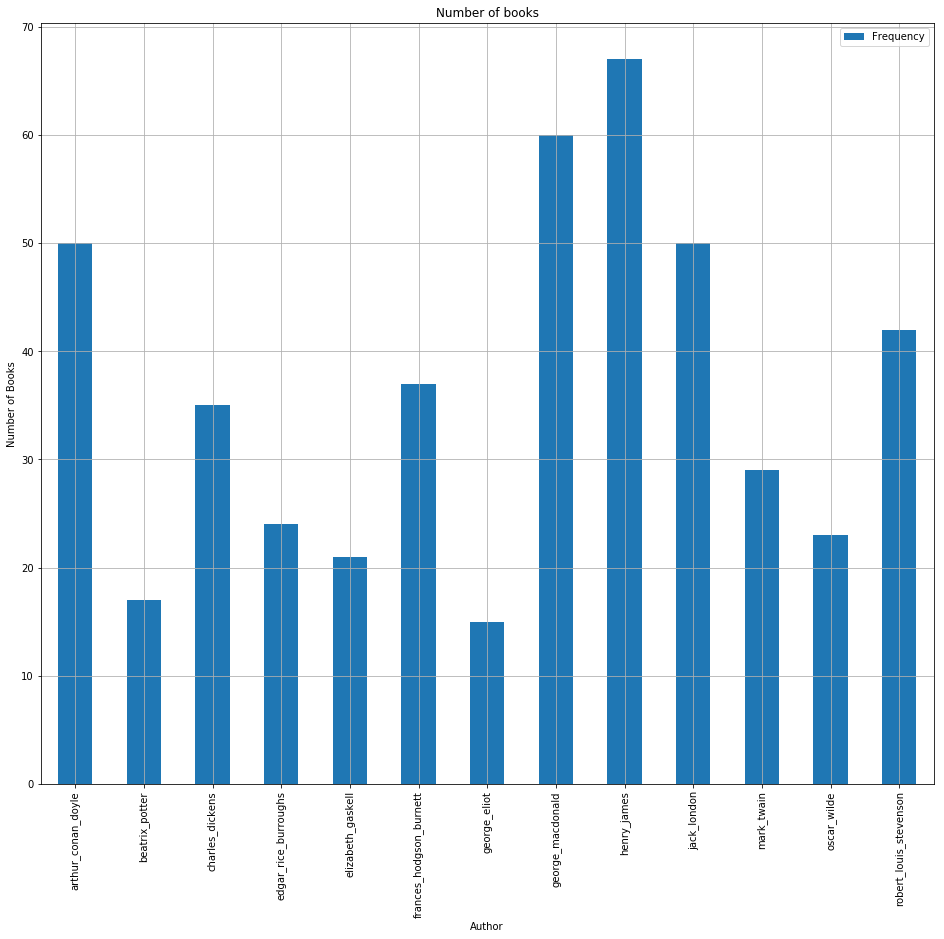

In [5]:
ax = books_freq.plot(kind='bar', figsize=(16,14), title='Number of books', grid=True)
ax.set_xlabel("Author")
ax.set_ylabel("Number of Books")

# Word Length Distributions

In [6]:
class Text():

    def __init__(self, text):
        self.text = text.lower()
        self.tokens = TweetTokenizer().tokenize(self.text)
        self.sentences = sent_tokenize(self.text)
        self.total_number_of_tokens = len(self.tokens)
        self.row = {}
        #self.build_row()

    def build_row(self):
        self.gram_data()
        self.pos_data()
        self.word_richness()
        self.word_length_data()
        self.sentence_length_data()


    def gram_data(self):
        for n in range(1, 3):
            n_grams = ngrams(self.tokens, n)
            number_of_n_grams = self.total_number_of_tokens - n + 1
            self.row.update( { " ".join(n_gram) : (lambda count: count / number_of_n_grams)(count) for ( n_gram, count ) in self.count_map(n_grams).items() } )

    def count_map(self, items):
        count_map = {}
        for item in items:
            if item in count_map:
                count_map[item] += 1
            else:
                count_map[item] = 1
        return count_map

    def percentage_map(self, count_map, total):
        return( { key : (lambda count: count / total)(count) for ( key, count ) in count_map.items() } )


    def pos_data(self):
        pos_tags = nltk.pos_tag(self.tokens)
        for n in range(1, 3):
            pos_n_grams = []
            for i in range(0, len(pos_tags)+1-n):
                pos_n_grams.append( tuple([ tag for (word, tag) in  pos_tags[i:i+n]]) )
            self.row.update( {  " ".join(pos_n_gram) : (lambda count: count / len(pos_n_grams))(count) for ( pos_n_gram, count ) in self.count_map(pos_n_grams).items() } )


    def word_lengths(self):
        word_lengths = []
        forbidden = [".", ",", "?", "!", "\"","\'",";",":"]
        for word in self.tokens:
            if word not in forbidden:
                word_lengths.append(len(word))
        return sorted(word_lengths)

    def sentence_lengths(self):
        sentence_lengths = []
        for sentence in self.sentences:
            sentence_lengths.append(len(sentence.split(" ")))
        return sorted(sentence_lengths)

    def word_length_distr(self):
        word_lengths = self.word_lengths()
        return self.percentage_map( self.count_map(word_lengths), len(word_lengths) ) 

    def sentence_lengths_distr(self):
        sentence_lengths = self.sentence_lengths()
        return percentage_map( count_map(sentence_lengths), len(sentence_lengths) )

    def word_length_data(self):
        word_lengths = self.word_lengths()
        self.row.update( {'word_length_avg': np.mean(word_lengths),'word_length_std_dev': np.std(word_lengths)} )

    def sentence_length_data(self):
        sentence_lengths = self.sentence_lengths()
        self.row.update( {'sentence_length_avg': np.mean(sentence_lengths), 'sentence_length_std_dev': np.std(sentence_lengths) })

    def word_richness(self):
        self.row.update( {'word_richness': len(self.tokens) / len(set(self.tokens)) } )
        


In [7]:
author = "george_eliot"
path = "./data/texts_stripped/" + author
books = os.listdir(path)

word_len_dis = {}
books_df = pd.DataFrame()
for i in range(0, len(books)):
    text = Text(open(path + "/" + books[i],'r').read())
    text.word_length_data()
    text.sentence_length_data()
    word_len_dis[books[i]]= text.word_length_distr()
    book_df = pd.DataFrame(text.row,index =[books[i]])
    books_df = books_df.append(book_df)
books_df

,sentence_length_avg,sentence_length_std_dev,word_length_avg,word_length_std_dev
adam_bede.txt,22.578768,17.081693,4.214895,2.250046
brother_jacob.txt,26.129032,20.096634,4.475072,2.527197
daniel_deronda.txt,20.173027,16.818813,4.440592,2.522205
"felix_holt,_the_radical.txt",20.897552,16.703509,4.418458,2.480956
"george_eliot's_life,_vol._i_(of_3).txt",22.461383,22.939580,4.436686,2.737701
"george_eliot's_life,_vol._ii_(of_3).txt",20.607681,26.889104,4.408410,2.726404
"george_eliot's_life,_vol._iii_(of_3).txt",20.387246,21.212919,4.392738,2.699598
how_lisa_loved_the_king.txt,36.040323,22.455116,4.336638,2.109396
impressions_of_theophrastus_such.txt,36.537201,26.042263,4.745950,2.808715
middlemarch.txt,19.895432,15.808332,4.427191,2.511383


Text(0.5,0,'sentence_length_avg')

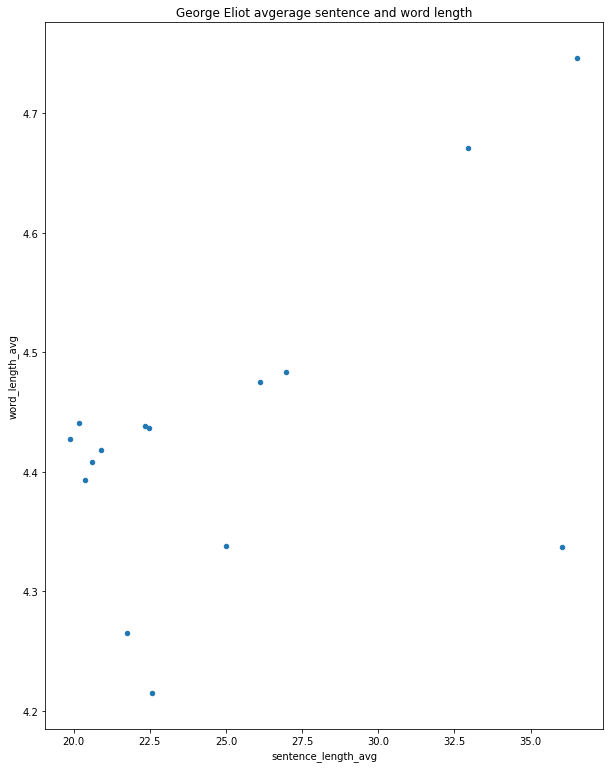

In [8]:
ax = books_df.plot.scatter(x="sentence_length_avg", y="word_length_avg",figsize=(10,13), title='George Eliot avgerage sentence and word length')
ax.set_ylabel("word_length_avg")
ax.set_xlabel("sentence_length_avg")

In [9]:
books_df["sentence_length_avg"].corr(books_df["word_length_avg"])

0.5515770598663263

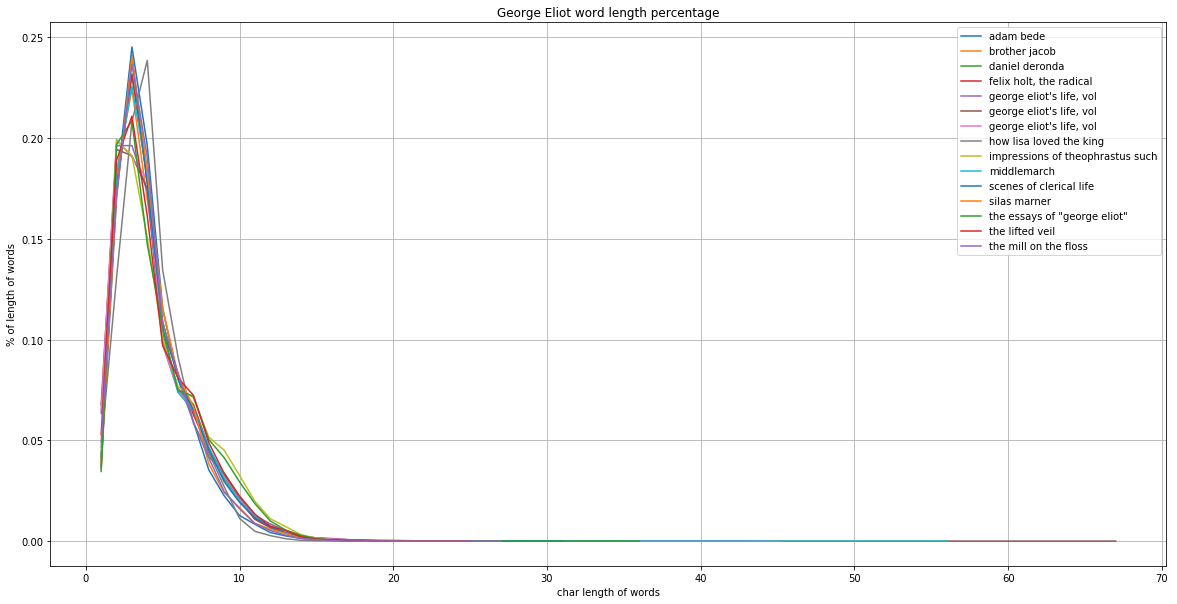

In [10]:
plt.figure(figsize=(20,10))

for book in word_len_dis.keys():
    label = book.split(".")[0]
    label = label.replace("_", " ")
    plt.plot(  word_len_dis[book].keys(), word_len_dis[book].values(), label= label)

plt.xlabel('char length of words')
plt.ylabel('% of length of words')
plt.title( 'George Eliot word length percentage' )
plt.grid(True)
plt.legend()
plt.show()

In [11]:
author = "elizabeth_gaskell"
path = "./data/texts_stripped/" + author
books = os.listdir(path)

word_len_dis = {}
books_df = pd.DataFrame()
for i in range(0, len(books)):
    text = Text(open(path + "/" + books[i],'r').read())
    text.word_length_data()
    text.sentence_length_data()
    word_len_dis[books[i]]= text.word_length_distr()
    book_df = pd.DataFrame(text.row,index =[books[i]])
    books_df = books_df.append(book_df)
books_df

,sentence_length_avg,sentence_length_std_dev,word_length_avg,word_length_std_dev
a_dark_night's_work.txt,21.128847,18.435456,4.327118,2.369428
an_accursed_race.txt,27.897674,17.912156,4.554565,2.457043
cranford.txt,28.976652,23.538176,4.054361,2.327055
"curious,_if_true.txt",23.223604,19.180071,4.255879,2.306401
half_a_life-time_ago.txt,20.540676,16.980089,4.056224,2.237389
lizzie_leigh.txt,16.128552,13.440934,4.121014,2.085431
mary_barton.txt,17.452276,15.752652,4.173311,2.207385
my_lady_ludlow.txt,22.793550,19.404705,4.170465,2.309279
north_and_south.txt,16.034782,14.681083,4.220890,2.318980
round_the_sofa.txt,37.281553,28.938977,4.094250,2.331923


Text(0.5,0,'sentence_length_avg')

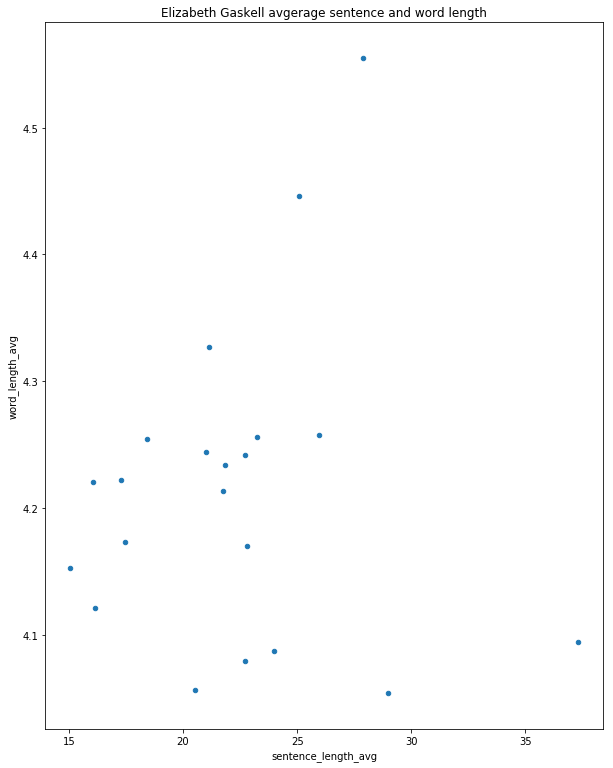

In [12]:
ax = books_df.plot.scatter(x="sentence_length_avg", y="word_length_avg",figsize=(10,13), title='Elizabeth Gaskell avgerage sentence and word length')
ax.set_ylabel("word_length_avg")
ax.set_xlabel("sentence_length_avg")

In [13]:
books_df["sentence_length_avg"].corr(books_df["word_length_avg"])

0.05360175637494839

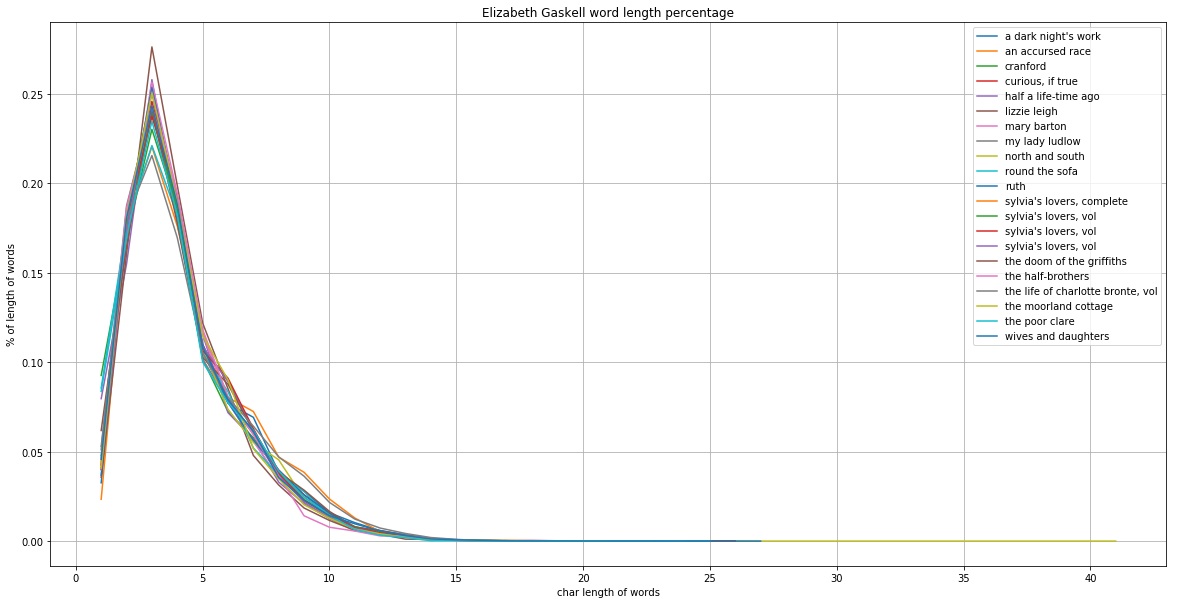

In [14]:
plt.figure(figsize=(20,10))

for book in word_len_dis.keys():
    label = book.split(".")[0]
    label = label.replace("_", " ")
    plt.plot(  word_len_dis[book].keys(), word_len_dis[book].values(), label= label)

plt.xlabel('char length of words')
plt.ylabel('% of length of words')
plt.title( 'Elizabeth Gaskell word length percentage' )
plt.grid(True)
plt.legend()
plt.show()